# Kaggle 競賽: Home Credit Default Risk

競賽網址: https://www.kaggle.com/c/home-credit-default-risk

Home Credit (捷信消費金融有限公司) 是中東歐/亞洲的一家消費金融提供商，為客戶提供金融服務。  
他們希望能通過資料探勘和機器學習來判斷客戶的貸款違約機率。

## 資料簡介  
  
Home Credit 提供的資料如下：

1. **application_train/test - 客戶申請表**: 包含了客戶是否違約(1/0的目標變數)、客戶申請貸款資料(貸款類型、貸款總額、年金)、客戶基本資料(性別、 年齡、家庭、學歷、職業、行業、居住地情況)、客戶財務資訊(年收入、房/車狀況)、以及其他申請時提供的資料等等。
  
2. **bureau/bureau_balance - 由其他金融機構提供給徵信單位的客戶信用記錄歷史**: 包含了客戶在徵信單位的信用記錄、違約金額、違約時間等等。以時間序列的形式進行記錄(以月為單位)。
  
3. **POS_CASH_balance - 客戶在Home Credit資料庫中POS(point of sales)和現金貸款紀錄**: 包含了客戶已付款和未付款的狀況(以月為單位)。
  
4. **credit_card_balance - 客戶在Home Credit資料庫中信用卡的紀錄**: 包含了客戶消費次數、消費金額等等(以月為單位)。
  
5. **previous_application - 客戶先前的申請記錄**: 包含了客戶所有歷史申請記錄，如申請資料和申請結果等等。
  
6. **installments_payments - 客戶先前信用卡的還款記錄**: 包含了客戶的還款狀況(還款日期、是否逾期、還款金額、是否欠款等等)。

## 競賽目標

**競賽最終要求提交每個目標ID的違約機率，並以此計算得到的AUC作為評分標準。**


### 評分標準: AUC 簡介

ROC-AUC 是一種常見的分類指標，稱為 [Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

我們可藉由 [Reciever Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) 繪製出 True Positive Rate (TPR) 和 False Positive Rate (FPR) 的關係圖：

![image](./ROC-curve.png)

然後 [Area Under the Curve (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) 是單純 ROC 底下的涵蓋面積。所以可以看出如上圖，藍色模型優於紅色模型，紅色模型又優於完全隨機亂猜的模型(黑色斜直線)。

## 前置作業

### Imports

基本的python套件: `numpy`, `pandas`, `sklearn`, `matplotlib`

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

### 讀取資料

總共有九個檔案：兩個主要的csv檔可以用來訓練模型(有標籤的是train，沒標籤的是test)，來有其他六個包含額外資訊的csv檔。

In [2]:
print(os.listdir("./input/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [7]:
app_train = pd.read_csv('./input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


訓練資料共有 307511 個觀察點以及 122 個特徵變數 (包含`TARGET`，也就是我們要預測的東西)。

In [8]:
app_test = pd.read_csv('./input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


test資料比較小而且沒有 `TARGET` 欄位。 

## 探索式資料分析

探索式資料分析 (Exploratory Data Analysis, EDA) 是一種探索未知的過程。我們會除了基本的統計分析外，會特別尋找資料中的偏差性、異常值、重複的模式或彼此的關係。EDA的目標是讓我們了解資料，並從中取出可以利用的特徵。我們通常會從 High-Level Overview 開始尋找，然後隨著發現一些規律或有趣的結果後逐漸收斂到較小的分析範圍。

### 檢查標籤分布

In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

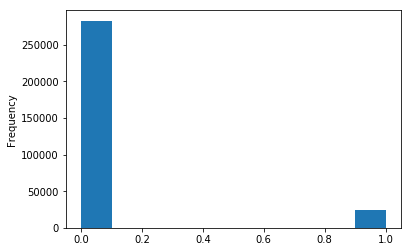

In [6]:
app_train['TARGET'].astype(int).plot.hist()

發現標籤中只有 0 跟 1，而且比例非常不平均(Unbalanced分類問題)。

### 檢查遺失值

In [9]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [10]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


在未來我們會嘗試去填補這些遺失值。

### 特徵資料型態


In [9]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

`int64` 和 `float64` 是數值資料，而 `object` 是類別資料。 

其中 `object` (類別資料) 又可以列出以下類別：

In [10]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

可以發現有些類別很少出現，我們在未來亦需要特別處理它們。

### 對類別資料進行編碼

由於大多數的機器學習或深度學習模型沒辦法處理異質資料(除了一些特別設計的 Decision Tree 或 Gradient Boosting Machine以外)，所以我們會需要找到一個方法去編碼上述的那些類別資料。常見的方法有幾種：

* Label encoding: 將所有類別由 1 編碼到 N，特徵向量維度不變。

![image](./label_encoding.png)

* One-hot encoding: 類似統計上的 Dummy-Variable，但不考慮線性相依問題所以有幾個類別就產生幾維度的特徵向量(如 A、B、C 三類，會直接編碼成\[1,0,0\]、\[0,1,0\]、\[0,0,1\])。 

![image](./one_hot_encoding.png)

Label Encoding 會把所有類別由 1 編碼到 N，所以常常會產生無意義的順序性(比如貓、狗、豬，若編碼成 1、2、3 時可能會讓電腦誤會成他們具有順序性或者數值大小關係)。但 One-hot Encoding 不會。所以我們決定在只有兩類的類別資料實作 Label Encoding，然後其他兩類別以上的類別資料做 One-hot Encoding



我們使用 Scikit-Learn 的 `LabelEncoder` 和 Pandas 的 `get_dummies(df)` 來實作編碼方法。

In [12]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


In [13]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### 建立 Training Set 和 Testing Set

In [14]:
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


### 檢查異常值

我們使用 `describe` 函式來檢視統計敘述。日期相關的值是負的所以我們要加上負號，然後他記錄天數所以我們除以365來以年為單位。



In [14]:
(-app_train['DAYS_BIRTH'] / 365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

我們可以看到 `DAYS_BIRTH` 部分沒有太大的異常。

In [15]:
(-app_train['DAYS_EMPLOYED']/ 365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

這肯定有異常值，最小值-1000並不合理。我們接著檢查 `DAYS_EMPLOYED` 的分布：

Text(0.5,0,'Days Employment')

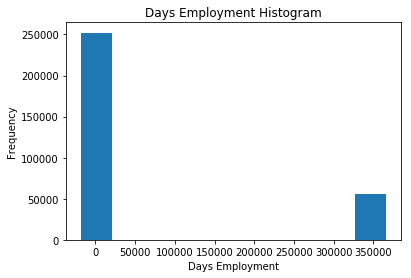

In [16]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

我們發現 `DAYS_EMPLOYED` 的值大多分布在 50000 以下，所以可以合理懷疑 300000 以上的值是異常值。我們把他們都設為 `np.nan`。

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Text(0.5,0,'Days Employment')

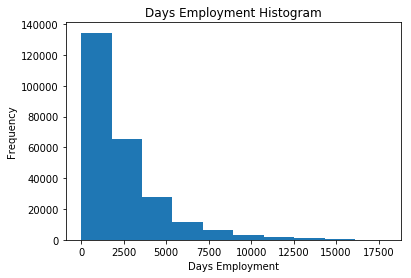

In [16]:
anom = app_train[app_train['DAYS_EMPLOYED'] > 300000]
non_anom = app_train[app_train['DAYS_EMPLOYED'] <= 300000]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] > 300000

rep = {val: np.nan for val in app_train['DAYS_EMPLOYED'] if val > 300000}
app_train['DAYS_EMPLOYED'].replace(rep, inplace = True)

(-app_train['DAYS_EMPLOYED']).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

testing set 也要做同樣的動作(將異常值取代為 `np.nan` )。

In [15]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] > 300000
rep = {val: np.nan for val in app_test['DAYS_EMPLOYED'] if val > 300000}
app_test["DAYS_EMPLOYED"].replace(rep, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### 相關係數

我們直接使用 `.corr` 進行相關係數的計算。

In [18]:
correlations = app_train.corr()
target_corr = correlations['TARGET'].sort_values()

print('Most Positive Correlations:\n', target_corr.tail(15))
print('\nMost Negative Correlations:\n', target_corr.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Text(0.5,1,'Correlation Heatmap')

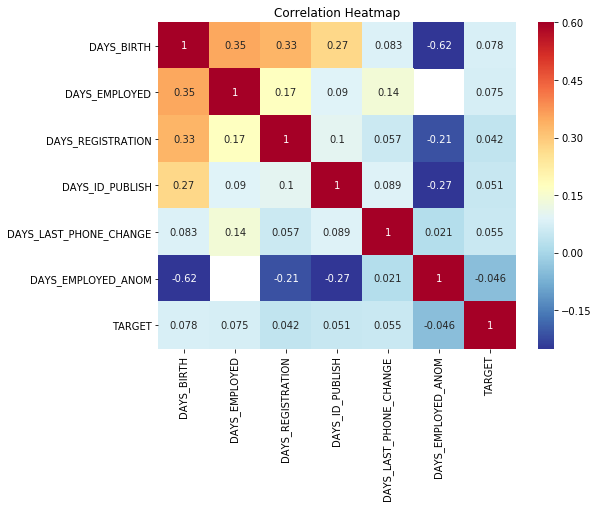

In [21]:
plt.figure(figsize = (8, 6))

plt_data = app_train[[c for c in app_train.columns if 'DAYS_' in c] + ['TARGET']]

sns.heatmap(plt_data.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

可以發現 `DAYS_BIRTH` 是最相關的變數。

由於一般的分布圖沒辦法看出什麼有用的資訊，所以我們使用 [核密度估計](https://en.wikipedia.org/wiki/Kernel_density_estimation) (kernel density estimation, KDE) 來繪製 `DAYS_BIRTH` 和 `TARGET` 的關係圖。 KDE 可以被視為平滑過的直方圖。

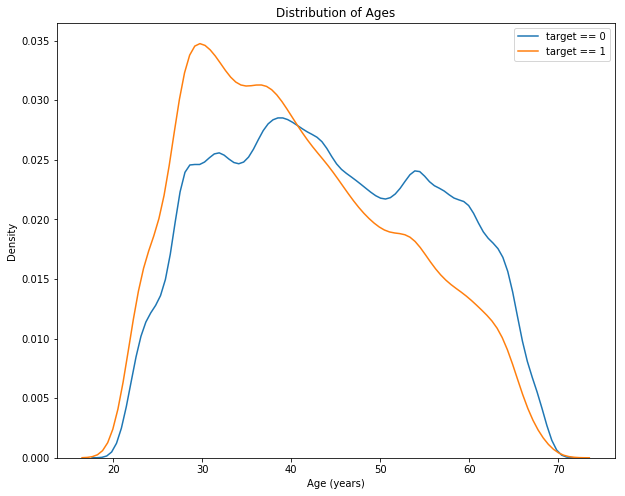

In [22]:
plt.figure(figsize = (10, 8))
sns.kdeplot(-app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

sns.kdeplot(-app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.show()

我們可以發現，沒有違約呈常態分佈，但年齡越低時違約的比例越高。

## 訓練模型

### Baseline

由於是二分類問題，所以最低標準的準確率一定是 0.5。

### Logistic Regression

In [36]:
from sklearn.preprocessing import MinMaxScaler, Imputer

if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
features = list(train.columns)

test = app_test.copy()

imputer = Imputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))
imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [37]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001)

log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.066677
1,100005,0.128855
2,100013,0.084450
3,100028,0.060502
4,100038,0.127878


Logistic Regression 的輸出結果會是機率值，我們也可以設定一個閥值後將它變成1或0的類別(二分類)。

In [40]:
submit.to_csv('log_reg_baseline.csv', index = False)

**Logistic regression 的成績為 0.671。**

### Random Forest

隨機森林演算法是決策樹的延伸，我們也在這邊測試。

In [41]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [42]:
random_forest.fit(train, train_labels)

feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


In [43]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline.csv', index = False)

**Random Forest 的成績為 0.678。**

### Gradient Boosting Machine
Kaggle 競賽中經常見到 [Gradient Boosting Machine](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)，其中 [LightGBM library](http://lightgbm.readthedocs.io/en/latest/Quick-Start.html) 是大家常用的 python 套件之一。我們使用 5-fold 的 Cross validation，然後類別資料一律用 One-hot Encoding 編碼。

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    labels = features['TARGET']
    
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        cat_indices = 'auto'
    
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        
        cat_indices = []
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                cat_indices.append(i)
    
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    feature_names = list(features.columns)
    features = np.array(features)
    test_features = np.array(test_features)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    feature_importance_values = np.zeros(len(feature_names))
    test_predictions = np.zeros(test_features.shape[0])
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(features):
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
      
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)

        best_iteration = model.best_iteration_
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [24]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 239)
Testing Data Shape:  (48744, 239)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798776	train's binary_logloss: 0.547732	valid's auc: 0.755302	valid's binary_logloss: 0.563582
[400]	train's auc: 0.828115	train's binary_logloss: 0.518495	valid's auc: 0.755183	valid's binary_logloss: 0.54559
Early stopping, best iteration is:
[330]	train's auc: 0.818572	train's binary_logloss: 0.528099	valid's auc: 0.755926	valid's binary_logloss: 0.551342
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798672	train's binary_logloss: 0.547978	valid's auc: 0.758343	valid's binary_logloss: 0.563567
Early stopping, best iteration is:
[289]	train's auc: 0.812801	train's binary_logloss: 0.533928	valid's auc: 0.758486	valid's binary_logloss: 0.555107
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.797711	train's binary_logloss: 0.549295	valid's auc: 0.763014	valid's bina

In [27]:
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending = False).reset_index()
    
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

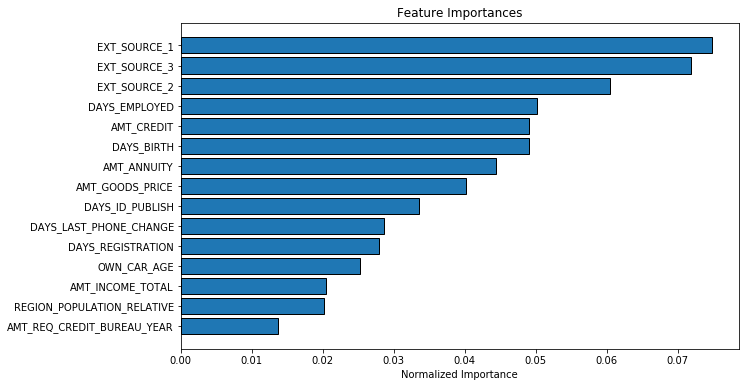

In [28]:
fi_sorted = plot_feature_importances(fi)

In [29]:
submission.to_csv('baseline_lgb.csv', index = False)

**Gradient Boosting Machine 的成績為 0.735。**

## 進階特徵工程

根據基本財務方面的Domain Knowledge判斷，我們可以從現有的feature中計算或者提取出新的feature。

### 更新 one-hot-encoding 函式

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

DEBUG_MODE = False
NUM_ROWS = 10000 if DEBUG_MODE else None

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### 新增 application 相關資訊

#### 資料清理：
* 將`CODE_GENDER == "XNA"`作為異常值刪除
* 二類別資料(如`'CODE_GENDER`、`FLAG_OWN_CAR`和`FLAG_OWN_REALTY`)就用0/1表示，其他類別資料則用One-Hot Encoding
* 大於300000的天數資料改為NaN

#### 特徵工程：
* `INCOME_CREDIT_PERCENT`: 收入與信用額度(可貸款額度)的比例
* `ANNUITY_INCOME_PERCENT`: 年金與收入的比例
* `CREDIT_TERM`:  以月為單位的付款期限
* `DAYS_EMPLOYED_PERCENT`: 在職時間長度與歲數的比例
* `INCOME_PER_PERSON`: 家庭成員平均所得
* `PAYMENT_RATE`: 年金與信用額度的比值

In [3]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('input/application_test.csv', nrows= num_rows)
    df = df.append(test_df).reset_index()
    
    df = df[df['CODE_GENDER'] != 'XNA']
    
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

print("Process application train/test...", end="")
df = application_train_test(NUM_ROWS)
print("DONE! (df shape: ",df.shape,")")

Process application train/test...DONE! (df shape:  (356251, 248) )


### 新增 bureau 相關資訊

#### 資料清理：
* 使用`SK_ID_CURR`將資料集合併

#### 特徵工程
* 因為同個`SK_ID_CURR`對應到很多筆資料，所以我們使用Aggregation方法：
    * 對於數值資料，我們取他們的`min`、`max`、`sum`、`mean`、`var`和`size`
    * 對於類別資料，我們僅取`mean`(對已經encode後的結果)
* 我們將所有特徵分為`CREDIT_ACTIVE == 1`和`CREDIT_ACTIVE == 0`兩種，再進行Aggregation

In [4]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }

    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

print("Process bureau and bureau_balance...", end="")
bureau = bureau_and_balance(NUM_ROWS)
df = df.join(bureau, how='left', on='SK_ID_CURR')
print("DONE! (Bureau df shape:", bureau.shape,")")
del bureau
gc.collect()

Process bureau and bureau_balance...DONE! (Bureau df shape: (305811, 116) )


0

### 新增 previous application 相關資訊

#### 資料清理：
* 使用`SK_ID_CURR`將資料集合併
* 大於300000的天數資料改為NaN

#### 特徵工程
* `APP_CREDIT_PERC`: 借貸申請成功比例
* 分別對數值和類別資料使用Aggregation方法
* 分成`NAME_CONTRACT_STATUS_Approved == 1`和`NAME_CONTRACT_STATUS_Refused == 1`兩類


In [5]:
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)

    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

print("Process previous_applications...", end="")
prev = previous_applications(NUM_ROWS)
df = df.join(prev, how='left', on='SK_ID_CURR')
print("DONE! (Previous applications df shape:", prev.shape, ")")
del prev
gc.collect()

Process previous_applications...DONE! (Previous applications df shape: (338857, 249) )


0

### 新增 POS-Cash Balance 相關資訊

#### 資料清理：
* 使用`SK_ID_CURR`將資料集合併

#### 特徵工程
* `POS_COUNT`: 計算交易總次數
* 分別對數值和類別資料使用Aggregation方法
* 數值方面僅對`MONTHS_BALANCE`、`SK_DPD`和`SK_DPD_DEF`進行Aggregation

In [6]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

print("Process POS-CASH balance...", end="")
pos = pos_cash(NUM_ROWS)
df = df.join(pos, how='left', on='SK_ID_CURR')
print("DONE! (Pos-cash balance df shape:", pos.shape,")")
del pos
gc.collect()

Process POS-CASH balance...DONE! (Pos-cash balance df shape: (337252, 18) )


0

### 新增 installments 相關資訊

#### 資料清理：
* 使用`SK_ID_CURR`將資料集合併

#### 特徵工程
* `PAYMENT_PERC`: 分期付款償還比例
* `PAYMENT_DIFF`: 分期付款剩餘欠額
* `DPD`: 遲繳天數(大於等於0)
* `DBD`: 提前繳款天數(大於等於0)
* `INSTAL_COUNT`: 總分期付款次數
* 分別對數值和類別資料使用Aggregation方法

In [7]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)

    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

print("Process installments payments...",end="")
ins = installments_payments(NUM_ROWS)
df = df.join(ins, how='left', on='SK_ID_CURR')
print("DONE! (Installments payments df shape:", ins.shape,")")
del ins
gc.collect()

Process installments payments...DONE! (Installments payments df shape: (339587, 26) )


0

### 新增 Credit Card 相關資訊

#### 資料清理：
* 使用`SK_ID_CURR`將資料集合併
* 捨棄`SK_ID_PREV`

#### 特徵工程
* `CC_COUNT`: 信用卡交易次數
* 因為全都是數值資料，所以直接做Aggregation方法

In [8]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)

    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

print("Process credit card balance...", end="")
cc = credit_card_balance(NUM_ROWS)
df = df.join(cc, how='left', on='SK_ID_CURR')
print("DONE! (Credit card balance df shape:", cc.shape,")")
del cc
gc.collect()

Process credit card balance...DONE! (Credit card balance df shape: (103558, 141) )


0

...最後得到一個完整的特徵表！

In [2]:
try:
    print('Training data (with Domain Knowledge) shape: ', df.shape)
except:
    df = pd.read_csv("full_dataset.csv", index_col=0)
    print('Training data (with Domain Knowledge) shape: ', df.shape)
    
df.head()
#df.to_csv('full_dataset.csv', index=False)

Training data (with Domain Knowledge) shape:  (356251, 797)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
index,,,,,,,,,,,,,,,,,,,,,
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 使用 Bayesian Optimization 尋找最佳參數

貝葉斯優化 (Bayesian Optimization) 是一種比 GridSearch 和 RandomSearch 還要更加快速且精準的 Hyperparameters 尋找方法。

簡單來說，貝葉斯優化其實就是在解未知函式的情況下，根據已有的樣本預估函式最大值的一個演算法。

In [3]:
from bayes_opt import BayesianOptimization
import lightgbm

train_set = df[df['TARGET'].notnull()]
X = train_set.drop(['TARGET','SK_ID_CURR'], axis=1)
X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns] #LightGBM 不能處理 special JSON characters
y = train_set.TARGET
del train_set
gc.collect()

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=50, n_estimators=10000, learning_rate=0.05, output_process=False):

    categorical_columns = [col for col in X.columns if X[col].dtype == 'object']
    train_data = lightgbm.Dataset(data=X, label=y, categorical_feature=categorical_columns, free_raw_data=False)

    params = dict()
    params["learning_rate"] = 0.05
    params["nthread"] = 4
    params["application"] = "binary"
    params["boosting_type"] = 'goss'

    def lgbm_eval(num_leaves,
                  colsample_bytree,
                  subsample,
                  max_depth,
                  reg_alpha,
                  reg_lambda,
                  min_split_gain,
                  min_child_weight,
                  min_data_in_leaf
                 ):
        params["num_leaves"] = int(num_leaves)
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params['max_depth'] = int(max_depth)
        params['reg_alpha'] = max(reg_alpha, 0)
        params['reg_lambda'] = max(reg_lambda, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['min_data_in_leaf'] = int(max(min_data_in_leaf, 1))

        cv_result = lightgbm.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval=200, metrics=['auc'])

        return max(cv_result['auc-mean'])

    lgbBO = BayesianOptimization(lgbm_eval, {'num_leaves': (20, 100),
                                            'colsample_bytree' :(0.2, 1.0),
                                            'subsample': (0.2, 1.0),
                                            'max_depth': (3, 8.99),
                                            'reg_alpha': (0.00001, 0.2),
                                            'reg_lambda': (0.00001, 0.2),
                                            'min_split_gain': (0.00001, 0.1),
                                            'min_child_weight': (1, 100),
                                            'min_data_in_leaf': (20, 100)
                                            }, random_state=random_seed)
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    return lgbBO

opt_lgb = bayes_parameter_opt_lgb(X, y)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7689   |  0.5957   |  4.366    |  26.29    |  51.71    |  0.03774  |  99.73    |  0.08165  |  0.1544   |  0.8084   |
|  2        |  0.774    |  0.448    |  5.076    |  35.82    |  31.64    |  0.09727  |  92.73    |  0.112    |  0.06273  |  0.9106   |
|  3        |  0.7733   |  0.7397   |  5.343    |  51.21    |  61.93    |  0.0928   |  65.71    |  0.1337   |  0.01046  |  0.4616   |
|  4        |  0.7701   |  0.2451   |  4.077    |  92.67    |  95.04    |  0.07141  |  78.62    |  0.09235  |  0.1863   |  0.5251   |
|  5        |  0.7766   |  0.7466   |  6.893    |  60.28    |  37.76    |  0.06824  |  90.24    |  0.1593   |  0.08641  |  0.9343   |
|  6        |  0.778    |  0.8255   |  7.347    |  13.36    | 

|  37       |  0.7797   |  0.526    |  8.97     |  44.68    |  99.91    |  0.06122  |  66.53    |  0.149    |  0.036    |  0.2463   |
|  38       |  0.7795   |  0.9755   |  8.978    |  60.47    |  25.32    |  0.000381 |  80.4     |  0.1966   |  0.094    |  0.2889   |
|  39       |  0.7799   |  0.2614   |  8.983    |  53.3     |  95.96    |  0.07032  |  70.26    |  0.04785  |  0.09847  |  0.6262   |
|  40       |  0.7792   |  0.9552   |  8.99     |  14.79    |  65.27    |  0.005572 |  76.01    |  0.03835  |  0.08286  |  0.9639   |


得到最佳參數：

In [18]:
opt_params = opt_lgb.max['params']
print(opt_lgb.max)

{'target': 0.7801249519505453, 'params': {'colsample_bytree': 0.5110300074072807, 'max_depth': 8.977552395705573, 'min_child_weight': 62.01370018849643, 'min_data_in_leaf': 22.91634879128815, 'min_split_gain': 0.09186810956484048, 'num_leaves': 81.50397707140367, 'reg_alpha': 0.06776263027923575, 'reg_lambda': 0.0501364245150117, 'subsample': 0.9668094706053576}}


In [1]:
opt_params["num_leaves"] = int(opt_params["num_leaves"])
opt_params['colsample_bytree'] = max(min(opt_params['colsample_bytree'], 1), 0)
opt_params['subsample'] = max(min(opt_params['subsample'], 1), 0)
opt_params['max_depth'] = int(opt_params['max_depth'])
opt_params['reg_alpha'] = max(opt_params['reg_alpha'], 0)
opt_params['reg_lambda'] = max(opt_params['reg_lambda'], 0)
opt_params['min_split_gain'] = opt_params['min_split_gain']
opt_params['min_child_weight'] = opt_params['min_child_weight']
opt_params['min_data_in_leaf'] = int(max(opt_params['min_data_in_leaf'], 1))

from pprint import pprint
pprint(opt_params)

{'colsample_bytree': 0.5110300074072807,
 'max_depth': 8,
 'min_child_weight': 62.01370018849643,
 'min_data_in_leaf': 22,
 'min_split_gain': 0.09186810956484048,
 'num_leaves': 81,
 'reg_alpha': 0.06776263027923575,
 'reg_lambda': 0.0501364245150117,
 'subsample': 0.9668094706053576}


### n-folds Cross Validation Gradient Boosting Machine

In [4]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    train_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train_df.columns]
    test_df = df[df['TARGET'].isnull()]
    test_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test_df.columns]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()

    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        clf = LGBMClassifier(
            nthread=4,
            boosting_type='goss',
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=opt_params['num_leaves'],
            colsample_bytree=opt_params['colsample_bytree'],
            subsample=opt_params['subsample'],
            max_depth=opt_params['max_depth'],
            reg_alpha=opt_params['reg_alpha'],
            reg_lambda=opt_params['reg_lambda'],
            min_split_gain=opt_params['min_split_gain'],
            min_child_weight=opt_params['min_child_weight'],
            silent=-1,
            verbose=-1)
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric='auc', verbose=200, early_stopping_rounds=200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv("best_submission.csv", index=False)
    return feature_importance_df

print("Run LightGBM with kfold...\n")
kfold_lgbm_feat_importance = kfold_lightgbm(df, num_folds=5, stratified=False, debug=DEBUG_MODE)

Run LightGBM with kfold...

Starting LightGBM. Train shape: (307507, 797), test shape: (48744, 797)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.82126	training's binary_logloss: 0.227087	valid_1's auc: 0.781746	valid_1's binary_logloss: 0.242648
[400]	training's auc: 0.845368	training's binary_logloss: 0.215959	valid_1's auc: 0.788727	valid_1's binary_logloss: 0.239397
[600]	training's auc: 0.860919	training's binary_logloss: 0.209062	valid_1's auc: 0.791174	valid_1's binary_logloss: 0.23844
[800]	training's auc: 0.874259	training's binary_logloss: 0.203161	valid_1's auc: 0.792105	valid_1's binary_logloss: 0.23805
[1000]	training's auc: 0.885662	training's binary_logloss: 0.197873	valid_1's auc: 0.792788	valid_1's binary_logloss: 0.237769
[1200]	training's auc: 0.895931	training's binary_logloss: 0.192933	valid_1's auc: 0.792784	valid_1's binary_logloss: 0.23776
Early stopping, best iteration is:
[1118]	training's auc: 0.89192	training's binary_

![image](./submission.png)

**Score: 0.79190，排名約在1800名左右**

### Feature Importance (with Domain Knowledge)

我們可以觀察到，我們特徵工程取出的`PAYMENT_RATE`是最相關的。

而其他特徵工程取出的特徵值如`DAYS_EMPLOYED_PERC`、`ANNUITY_INCOME_PERC`等等也是很重要的Feature。

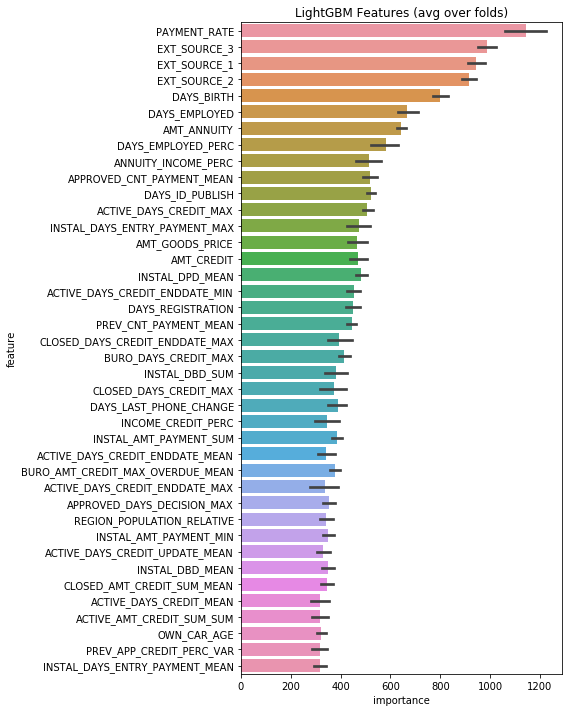

In [5]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

display_importances(kfold_lgbm_feat_importance)